In [1]:
import pandas as pd
import numpy as np

In [99]:
df_users = pd.read_csv('data/df_users.csv')
df_sales = pd.read_csv('data/df_sales.csv')

Вам доступны два файла (срез данных, аналогичный тем, что будут в боевом задании, но на несколько порядков меньше в своем размере), на которых вы можете проверить работоспособность своего кода

> `users`, который может быть получен с помощью команды <br>
> ```df_users = pd.read_csv(os.environ['PATH_DF_USERS'])```

> `sales`, который может быть получен с помощью команды <br>
> ```df_sales = pd.read_csv(os.environ['PATH_DF_SALES'])```

Давайте рассмотрим их отдельно

> Файл `users` хранит в себе информацию о пользователях. В файле присутствет три колонки

> `user_id` – идентификатор пользователя <br>
> `gender` – пол пользователя <br>
> `age` – возраст пользователя

> Например, пользователь с идентификатором `2481878` имеет пол `0`, причем ему `26` лет. Все пользователи в таблице уникальны

In [ ]:
users.head(3)

> Файл `sales` хранит информацию о покупках пользователей. В файле `sales` присутствет три колонки

> `user_id` – идентификатор пользователя <br>
> `day` – день, в который была совершена покупка пользователя <br>
> `sales` – сумма транзакции, которую совершил пользователь `user_id` в `day`

> Например, пользователь с идентификатором `4137940` в день `39` совершил покупку на `276` рублей

In [ ]:
sales.head(3)

> файлы `users` и `sales` имеют общий ключ `user_id`

In [ ]:
sales.info()

In [ ]:
users.info()

In [32]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)




In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and\
                        c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and\
                        c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [39]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

Проверим наши рассуждения на примере нормального распределения:

In [ ]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues

pvalues = get_pvalue_samples(
    a_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    b_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    size=5000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

In [ ]:
def get_pvalue_samples(df, size=250):
    pvalues = []
    for _ in tqdm(range(size)):
        users = df.user_id.unique()
        np.random.shuffle(users)
        users_len = len(users)
        group_a = df[df.user_id.isin(users[:users_len//2])].sales.values
        group_b = df[df.user_id.isin(users[users_len//2:])].sales.values
        _, p = stats.ttest_ind(group_a, group_b)
        pvalues.append(p)
    return pvalues

In [ ]:
pvalues = get_pvalue_samples(df_sales)
plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

In [ ]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.

    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы

    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

In [ ]:

## Делаем тут

1. Линеаризация

In [3]:
df_sales = df_sales[
    df_sales['day'].isin(np.arange(49, 56))
]

df_sales = df_sales[
    df_sales['sales'] < 5000
    ]

In [7]:
users_ids = df_sales.user_id.unique()
len(users_ids)


862263

In [11]:
# Рандомно наберем юзеров в 3 группы
np.random.seed(42)
np.random.shuffle(users_ids)
users_ids


array([1643439, 1556229, 5721132, ..., 6071014, 2832754, 9190479],
      dtype=int64)

In [18]:
group_a_one = list(users_ids[:len(users_ids)//3])
group_a_two = list(users_ids[len(users_ids)//3:len(users_ids)//3*2])
group_b = list(users_ids[len(users_ids)//3*2:])

user_a = group_a_one + group_a_two
user_b = group_b

In [19]:
len(group_a_one), len(group_a_two), len(group_b)


(287421, 287421, 287421)

## можно просуммировать или средний чек, или выручку на 1 клиента.

1. Чек

In [20]:
sales_a = df_sales[
    df_sales['user_id'].isin(user_a)
]
a_x = sales_a.groupby('user_id').sales.sum()
a_y = sales_a.groupby('user_id').sales.count()
a_x

user_id
1000002    1697
1000013     707
1000028     507
1000043    2429
1000061    2800
           ... 
9999955     430
9999957    1884
9999958    3438
9999968    5717
9999973     566
Name: sales, Length: 574842, dtype: int64

In [22]:
coef = np.sum(a_x) / np.sum(a_y)
a_lin = a_x - coef * a_y
a_lin

user_id
1000002     252.053746
1000013     225.351249
1000028      25.351249
1000043   -1905.838762
1000061   -3461.433768
              ...     
9999955    -533.297503
9999957   -1005.892508
9999958     548.107492
9999968    3308.756243
9999973      84.351249
Name: sales, Length: 574842, dtype: float64

In [23]:
sales_b = df_sales[
    df_sales['user_id'].isin(user_b)
]
b_x = sales_b.groupby('user_id').sales.sum()
b_y = sales_b.groupby('user_id').sales.count()
b_x


user_id
1000067    3444
1000131     500
1000149    2707
1000153    3867
1000155     638
           ... 
9999767    3152
9999775     963
9999803    3821
9999810    1386
9999889    2059
Name: sales, Length: 287421, dtype: int64

In [24]:
b_lin = b_x - coef * b_y
b_lin


user_id
1000067    1517.404994
1000131    -463.297503
1000149    1262.053746
1000153    1940.404994
1000155     156.351249
              ...     
9999767   -3109.433768
9999775      -0.297503
9999803    1894.404994
9999810     422.702497
9999889     132.404994
Name: sales, Length: 287421, dtype: float64

In [26]:
merged = df_sales.merge(df_users, how='left', on='user_id')
merged

,user_id,day,sales,gender,age
0,3848565,50,902,1,29
1,3848565,52,832,1,29
2,3848565,53,430,1,29
3,3848565,54,420,1,29
4,5801450,49,256,0,24
...,...,...,...,...,...
4706352,1403724,52,358,0,23
4706353,1403724,52,169,0,23
4706354,1403724,52,140,0,23
4706355,1403724,53,614,0,23


(4706357, 3)

In [29]:
def get_lineariz_groups(df, users_ids):
    user_a, user_b = get_groups(users_ids)
    sales_a = df[
        df['user_id'].isin(user_a)
    ]
    a_x = sales_a.groupby('user_id').sales.sum()
    a_y = sales_a.groupby('user_id').sales.count()
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    sales_b = df[
        df['user_id'].isin(user_b)
    ]
    b_x = sales_b.groupby('user_id').sales.sum()
    b_y = sales_b.groupby('user_id').sales.count()
    b_lin = b_x - coef * b_y
    return a_lin, b_lin

In [41]:

def get_pvalue_samples(_df, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        group_a, group_b =get_lineariz_groups(df_sales, users_ids)
        _, p = stats.ttest_ind(group_a, group_b)
        pvalues.append(p)
    return pvalues

In [42]:
pvalues = get_pvalue_samples(df_sales)

  0%|          | 0/1000 [00:00<?, ?it/s]

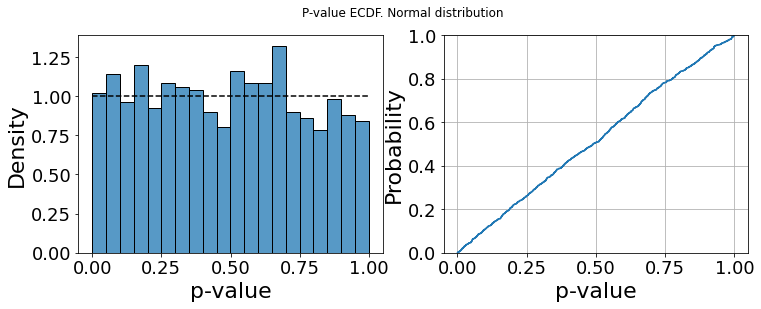

In [43]:
plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

In [38]:
pvalues

[0.6864706801043792,
 0.2972743071013617,
 0.3996914862289266,
 0.6605162821902772,
 0.9067356268492581,
 0.06348087115654087,
 0.24992653478796256,
 0.7246448482017579,
 0.048036699739986366,
 0.596025727239389,
 0.9616597976980894,
 0.8128206784548392,
 0.7417275992130222,
 0.6997089327582595,
 0.3344880376704993,
 0.9375300696733673,
 0.693533296247793,
 0.44741007212620987,
 0.4787918655793686,
 0.6236668682141944,
 0.5956595343463291,
 0.3069746998687772,
 0.4888854194270348,
 0.3313791408548512,
 0.156461907172251,
 0.5028997948095729,
 0.3843786196169995,
 0.09950342220050194,
 0.04842528884571187,
 0.7278090991844353,
 0.4504069413037902,
 0.24149927940067256,
 0.3914672096335565,
 0.5546565595000907,
 0.3754127578915837,
 0.40748755457302177,
 0.6706557629224091,
 0.15290289858540398,
 0.36950023968420864,
 0.042787869168031054,
 0.3268924380118873,
 0.11045037357209436,
 0.03508646212244762,
 0.08755109256761927,
 0.5394902635817758,
 0.28286324700700144,
 0.8990132178797379,

In [46]:
def get_groups(users_ids):
    np.random.shuffle(users_ids)
    group_a_one = list(users_ids[:len(users_ids)//3])
    group_a_two = list(users_ids[len(users_ids)//3:len(users_ids)//3*2])
    group_b = list(users_ids[len(users_ids)//3*2:])
    user_a = group_a_one + group_a_two
    user_b = group_b
    return user_a, user_b


In [47]:
def get_users_group(df, users_ids):
    user_a, user_b = get_groups(users_ids)
    sales_a = df[
        df['user_id'].isin(user_a)
    ]
    a = sales_a.groupby('user_id').sales.sum()
    sales_b = df[
        df['user_id'].isin(user_b)
    ]
    b = sales_b.groupby('user_id').sales.sum()
    return a, b

In [50]:
def get_pvalue_samples(_df, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        group_a, group_b = get_users_group(df_sales, users_ids)
        _, p = stats.ttest_ind(group_a, group_b)
        pvalues.append(p)
    return pvalues

In [51]:
pvalues = get_pvalue_samples(df_sales)

  0%|          | 0/1000 [00:00<?, ?it/s]

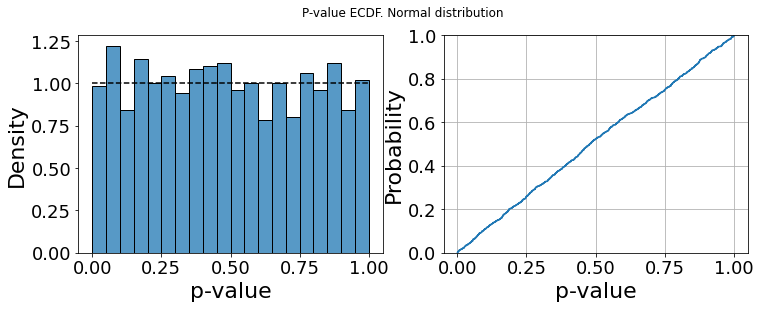

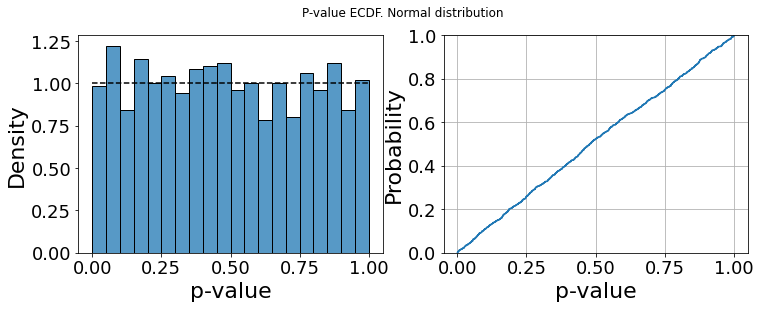

In [53]:
plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

2. Стратификация


In [65]:
strats = merged.groupby(['gender', 'age']).sales.mean()

In [55]:
merged

,user_id,day,sales,gender,age
0,3848565,50,902,1,29
1,3848565,52,832,1,29
2,3848565,53,430,1,29
3,3848565,54,420,1,29
4,5801450,49,256,0,24
...,...,...,...,...,...
4706352,1403724,52,358,0,23
4706353,1403724,52,169,0,23
4706354,1403724,52,140,0,23
4706355,1403724,53,614,0,23


In [59]:
def get_pvalue_samples(_df, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        group_a, group_b = get_groups(users_ids)
        group_a = _df[_df.user_id.isin(group_a)].sales.values
        group_b = _df[_df.user_id.isin(group_b)].sales.values
        _, p = stats.ttest_ind(group_a, group_b)
        pvalues.append(p)
    return pvalues

In [60]:
pvalues = get_pvalue_samples(df_sales)

  0%|          | 0/1000 [00:00<?, ?it/s]

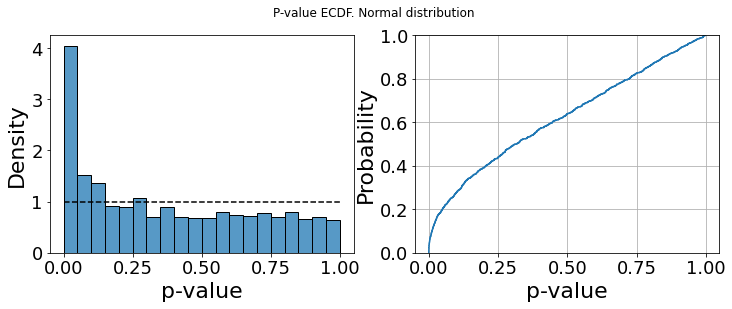

In [61]:
plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')


<AxesSubplot: xlabel='age', ylabel='sales'>

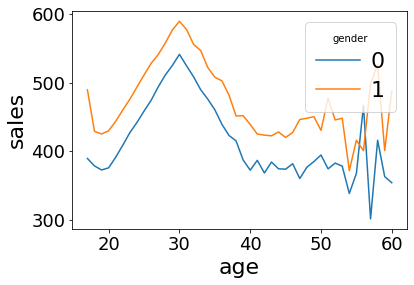

In [70]:
sns.lineplot(strats, x='age', y='sales', hue='gender')

In [69]:
strats = strats.reset_index()

In [71]:
len(strats)

88

In [72]:
strats.groupby('gender').sales.mean()

gender
0    413.747032
1    472.140079
Name: sales, dtype: float64

In [ ]:
merged.groupby(['gender', 'age']).sales.count() /

In [73]:
merged


,user_id,day,sales,gender,age
0,3848565,50,902,1,29
1,3848565,52,832,1,29
2,3848565,53,430,1,29
3,3848565,54,420,1,29
4,5801450,49,256,0,24
...,...,...,...,...,...
4706352,1403724,52,358,0,23
4706353,1403724,52,169,0,23
4706354,1403724,52,140,0,23
4706355,1403724,53,614,0,23


## Quped


In [74]:
np.arange(49, 56)


array([49, 50, 51, 52, 53, 54, 55])

In [109]:
np.arange(42, 49)

array([42, 43, 44, 45, 46, 47, 48])

In [90]:
um = merged.groupby('user_id', as_index=False).sales.sum()


In [91]:
um

,user_id,sales
0,1000002,1697
1,1000013,707
2,1000028,507
3,1000043,2429
4,1000061,2800
...,...,...
862258,9999955,430
862259,9999957,1884
862260,9999958,3438
862261,9999968,5717


In [98]:
um.merge(umt[], how='left', on='user_id')

,user_id,sales_x,sales_y
0,1000002,1697,1697.0
1,1000013,707,707.0
2,1000028,507,507.0
3,1000043,2429,2429.0
4,1000061,2800,2800.0
...,...,...,...
862258,9999955,430,NaN
862259,9999957,1884,NaN
862260,9999958,3438,NaN
862261,9999968,5717,NaN


In [97]:
umt = um.iloc[:100, :]
umt

,user_id,sales
0,1000002,1697
1,1000013,707
2,1000028,507
3,1000043,2429
4,1000061,2800
...,...,...
95,1001107,4695
96,1001115,2853
97,1001117,2109
98,1001132,3114


In [ ]:
df_sales = df_sales[
    df_sales['day'].isin(np.arange(49, 56))
]

# df_sales = df_sales[
#     df_sales['sales'] < 5000
#     ]

In [151]:
df_sales = df_sales[
    df_sales['sales'] < 5000
    ]

df_sales_test = df_sales[
    df_sales['day'].isin(np.arange(49, 56))
]

df_sales_before = df_sales[
    df_sales['day'].isin(np.arange(41, 48))
]

In [102]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [103]:
sales_a = df_sales_test[
    df_sales_test['user_id'].isin(user_a)
]
a = sales_a.groupby('user_id', as_index=False).sales.sum()
cov_a = df_sales_before[
    df_sales_before['user_id'].isin(user_a)
]
cov_a = cov_a.groupby('user_id', as_index=False).sales.sum()
cov_a.rename(columns={'sales': 'sales_cov'}, inplace=True)
a = a.merge(cov_a, how='left', on='user_id')

sales_b = df_sales_test[
    df_sales_test['user_id'].isin(user_b)
]
b = sales_b.groupby('user_id', as_index=False).sales.sum()
cov_b = df_sales_before[
    df_sales_before['user_id'].isin(user_b)
]
cov_b = cov_b.groupby('user_id', as_index=False).sales.sum()
cov_b.rename(columns={'sales': 'sales_cov'}, inplace=True)
b = b.merge(cov_b, how='left', on='user_id')
y_control = a.sales.values
y_control_cov = a.sales_cov.fillna(0).values
y_pilot = b.sales.values
y_pilot_cov = b.sales_cov.fillna(0).values

theta = calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov)
a_cuped = y_control - theta * y_control_cov
b_cuped = y_pilot - theta * y_pilot_cov

In [107]:
np.std(a_cuped), np.std(y_control)

(936.9483876148222, 1381.4215146460701)

In [108]:
np.std(b_cuped), np.std(y_pilot)


(931.4280628086295, 1386.3589500413725)

In [112]:
b[b.sales_cov.isna()]

,user_id,sales,sales_cov
22,1000824,387,NaN
130,1004552,583,NaN
147,1005153,421,NaN
176,1006067,517,NaN
205,1006957,887,NaN
...,...,...,...
287169,9991867,776,NaN
287203,9992954,235,NaN
287232,9993904,399,NaN
287352,9997717,378,NaN


In [124]:
stratum = df_users.groupby(['gender', 'age']).user_id.count() / len(df_users)
stratum

gender  age
0       17     0.000007
        18     0.000721
        19     0.005497
        20     0.017341
        21     0.033786
                 ...   
1       56     0.000018
        57     0.000017
        58     0.000016
        59     0.000012
        60     0.000044
Name: user_id, Length: 88, dtype: float64

In [121]:
stratum.loc[0, :]


gender  age
0       17         7
        18       721
        19      5497
        20     17341
        21     33786
        22     48394
        23     58519
        24     61569
        25     59292
        26     53528
        27     46468
        28     38775
        29     31965
        30     25678
        31     20300
        32     15636
        33     12468
        34      9367
        35      7240
        36      5411
        37      4235
        38      3230
        39      2486
        40      1952
        41      1401
        42      1143
        43       844
        44       683
        45       552
        46       414
        47       289
        48       241
        49       170
        50       141
        51       100
        52        74
        53        60
        54        44
        55        36
        56        20
        57        27
        58        12
        59        24
        60        57
Name: user_id, dtype: int64

In [123]:
stratum.loc[1, :]

gender  age
1       17        11
        18       517
        19      4105
        20     13049
        21     25619
        22     36516
        23     43880
        24     46244
        25     44349
        26     40105
        27     35345
        28     29579
        29     23854
        30     19149
        31     15316
        32     11843
        33      9493
        34      7165
        35      5561
        36      4269
        37      3292
        38      2453
        39      1869
        40      1498
        41      1134
        42       783
        43       611
        44       483
        45       407
        46       321
        47       206
        48       156
        49       156
        50        81
        51        98
        52        53
        53        52
        54        37
        55        37
        56        18
        57        17
        58        16
        59        12
        60        44
Name: user_id, dtype: int64

In [122]:
strats

,gender,age,sales
0,0,17,389.272727
1,0,18,378.327299
2,0,19,372.502663
3,0,20,375.615507
4,0,21,391.129206
...,...,...,...
83,1,56,400.621951
84,1,57,498.081395
85,1,58,526.079365
86,1,59,400.722222


In [155]:
df_users.age.max(), df_users.age.min()

(60, 17)

In [156]:
bins = np.linspace(15, 65, 6).astype(int)
bins

array([15, 25, 35, 45, 55, 65])

In [157]:
df_users['age_bin'] = pd.cut(df_users.age, bins=bins)


In [158]:
stratum = df_users.groupby(['gender', 'age_bin']).user_id.count() / len(df_users)

In [159]:
stratum

gender  age_bin 
0       (15, 25]    0.285126
        (25, 35]    0.261425
        (35, 45]    0.021937
        (45, 55]    0.001569
        (55, 65]    0.000140
1       (15, 25]    0.214290
        (25, 35]    0.197410
        (35, 45]    0.016799
        (45, 55]    0.001197
        (55, 65]    0.000107
Name: user_id, dtype: float64

In [139]:
df_users.age_bin.unique()

[(20, 30], (30, 40], (10, 20], (40, 50], (50, 60]]
Categories (5, interval[int64]): [(10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60]]

In [140]:
stratum.sum()

0.9999999999999999

In [152]:
(df_sales_test.groupby('user_id', as_index=False).sales.sum().\
merge(df_users[['user_id', 'gender', 'age_bin']], how='left', on='user_id').\
groupby(['gender', 'age_bin']).sales.std() * stratum).sum()

1318.0637410558022

In [153]:
df_sales_test.groupby('user_id', as_index=False).sales.sum().sales.std()

1331.9731537015923

In [162]:
(df_sales_test.groupby('user_id', as_index=False).sales.sum().
 merge(df_users[['user_id', 'gender', 'age_bin']], how='left', on='user_id').
 groupby(['gender', 'age_bin']).sales.std() * stratum).sum()

1303.823552801492